# Load world file and functions

Input world: name of a world folder in Minecraft saves, either in
* /User/.minecraft/saves/
* /Users/USER_NAME/Library/Application\ Support/minecraft/saves/
* MalmoPlatform/Minecraft/run/saves/ (if using Malmo)

In [93]:
import sys
sys.path.append('MCWorldlib.egg')
import mcworldlib as mc
from os.path import join

world_name = 'Falcon v1.02'
region = (-5,0)
# world = mc.load(join('inputs', 'worlds', world_name))

"""
    go to https://pessimistress.github.io/minecraft/ 
        and drag in .mca files in the region folder to find the region of interests
        * bottom left block -> (x_low, z_high)
        * top right block -> (x_high, z_low)
"""
building_ranges = { ## x_low, x_high, z_low, z_high, y_low, y_high
    'Singleplayer': (-2192, -2129, 144, 191, 28, 30),
    'Pilot 1': (-2176, -2097, 144, 207, 52, 54),
#     'Falcon v1.02': (-2112, -2049, 128, 207, 60, 62)   # r.-5.0.mca
#     'Falcon v1.02': (-2048, -2017, 128, 207, 60, 62)   # r.-4.0.mca
    'Falcon v1.02': (-2112, -2017, 128, 207, 60, 62)   # r.-4.0.mca
}

# Generate map images, json, and csv

The outputs include three parts:
* images of the 2D floor plans on different levels of the region of interest at `outputs/*_map.png` where * = 0,1,2,9
* a json file specifying the block type of all blocks within the region of interest at `outputs/blocks_in_building.json`
* a csv file that represent the region of interest that can be used as input to our gridworld framework at `outputs/darpa_maze.csv`

28 31 8 12 12 14


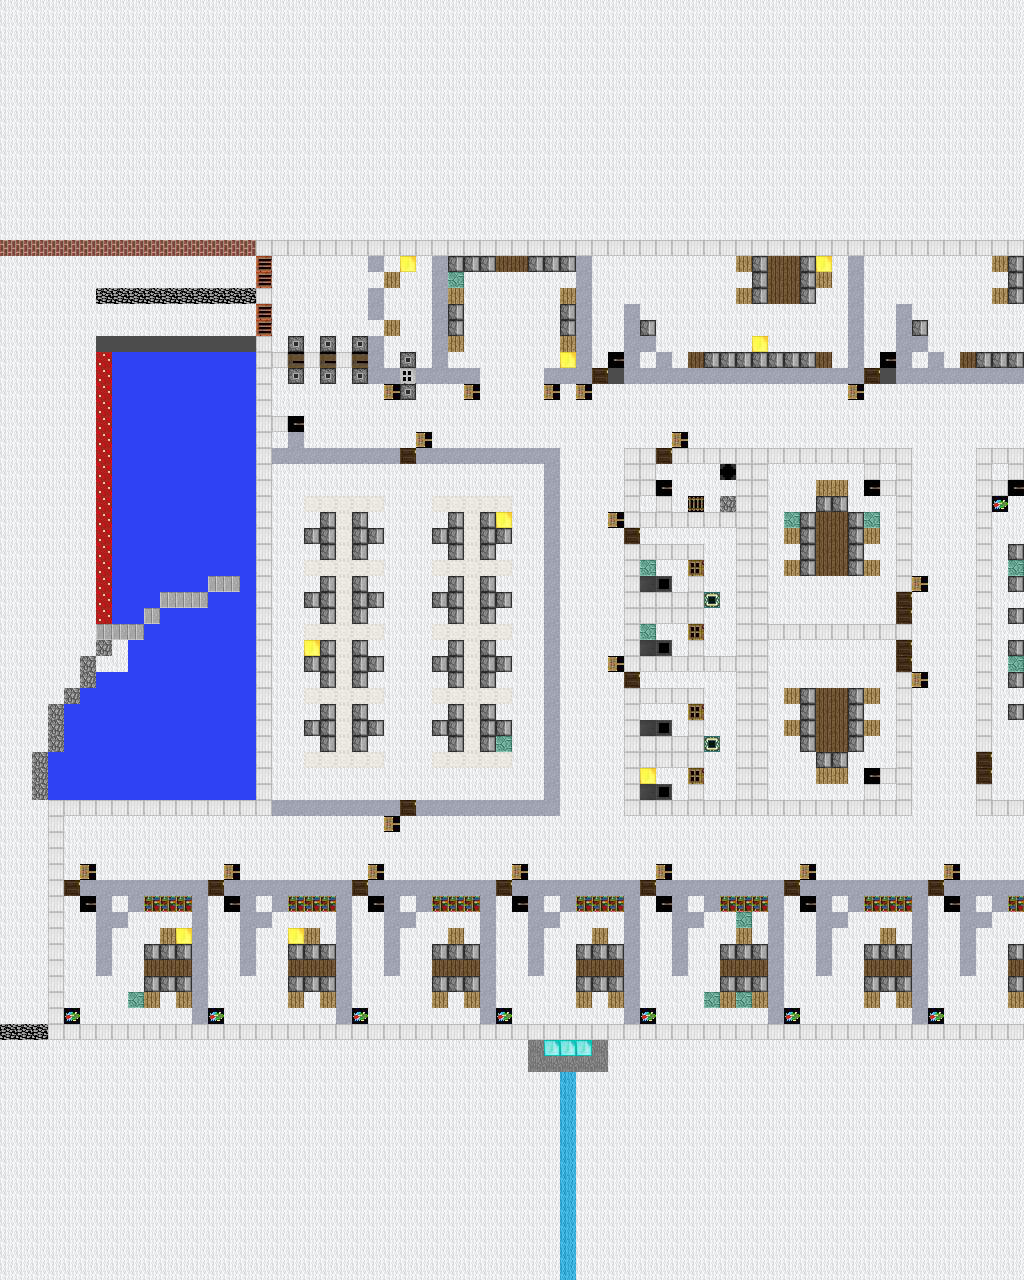

In [4]:
import map_generator as mg

## go to https://pessimistress.github.io/minecraft/ 
##    and drag in .mca files in the region folder to find the region of interests
# x_low = -2176  # x of the bottom left block
# x_high = -2097  # x of the top right block
# z_low = 144     # z of the top right block
# z_high = 207  # z of the bottom left block
# y_low = 52
# y_high = 54
# ranges = (x_low, x_high, z_low, z_high, y_low, y_high)

## comment this out if you are trying to find a new building
ranges = building_ranges[world_name]

all_blocks, important_blocks = mg.generate_maps(world, region, ranges)
mg.generate_json(all_blocks, ranges)
mg.generate_csv(important_blocks, ranges)

In [9]:
## might need to concate images/json together if they come from different regions
from PIL import Image
import json
from os.path import join

folder1 = join('outputs','_old','200617 Falcon -5.0')
folder2 = join('outputs','_old','200617 Falcon -4.0')

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# ----------------------------
# json
# ----------------------------

with open(join(folder1, 'blocks_in_building.json')) as json_file: json1 = json.load(json_file)
with open(join(folder2, 'blocks_in_building.json')) as json_file: json2 = json.load(json_file)
# json2 = json.loads(join(folder2, 'blocks_in_building.json'))
json3 = {}
json3['blocks'] = dict(json1['blocks'])
json3['blocks'].update(json2['blocks'])
print('number of blocks',len(json1['blocks'].keys()),len(json2['blocks'].keys()), len(json3['blocks'].keys()))

X_CHANGED = False
Z_CHANGED = False

json3['region'] = {}
for key in ['x_low','x_high','z_low','z_high','y_low','y_high']:  
    if 'low' in key:
        json3['region'][key] = min(json1['region'][key], json2['region'][key])
    else:
        json3['region'][key] = max(json1['region'][key], json2['region'][key])
    
    if json1['region'][key] != json2['region'][key]:
        if 'x' in key: X_CHANGED = True
        if 'z' in key: Z_CHANGED = True
            
with open('outputs/blocks_in_building.json', 'w') as outfile:
    json.dump(json3, outfile)

# ----------------------------
# images
# ----------------------------

for level in [0,1,2,9]:
    map_img = str(level) + '_map.png'
    im1 = Image.open(join(folder1, map_img))
    im2 = Image.open(join(folder2, map_img))
    if X_CHANGED: get_concat_h(im1, im2).save(join('outputs', map_img))
    if Z_CHANGED: get_concat_v(im1, im2).save(join('outputs', map_img))

number of blocks 15360 7680 23040


# Step 2: Visualize json blocks file in command line using pandas

Sometimes we want to visualize the map as time changes in command line. Pandas can provide simple formatting.

In [33]:
import json
import pandas as pd

objects2grids = {
    'wool':'v',
    'prismarine':'v',
    'gold_block':'vv',
    'wooden_door':'w',
    'gravel':'w',
    'fire':'',
    'air':''
}

with open('outputs/blocks_in_building.json') as json_file:
    data = json.load(json_file)
    blocks = data['blocks']
    
    print(data['region'].values())
    x_low, x_high, z_low, z_high, y_low, y_high = data['region'].values()
    
    ## for Singleplayer
    x_high = -2142
    
    world = []
    for z in range(z_low, z_high):
        row = []
        for x in range(x_low, x_high):
            
            ## we visualize the floor that's one level above the ground
            key = str((x,y_low+1,z)).replace('(','').replace(' ','').replace(')','')
            type = blocks[key]
            if type not in objects2grids.keys():
                type = 'w'
            else:
                type = objects2grids[type]
            row.append(type)
        world.append(row)
        
    df = pd.DataFrame(world, index = range(z_low, z_high), columns = range(x_low, x_high))

print(df)

dict_values([-2192, -2129, 144, 191, 28, 30])


# Step 3: Generate traces fromdata stream

In [111]:
import csv
import json
from pprint import pprint

world_name = 'Falcon v1.02'

## tested works: join('inputs','trajectories','march-24-2.csv')
csv_file = join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000005_trial_id_000015_messages.log')
COUNT_GAP = 5

player_names = {
    join('Singleplayer','march-5-5.csv'): 'Player396',
    join('Singleplayer','march-5-5.csv'): 'Player396',
    join('Sparky','jun10TB43-run5.csv'): 'Player985',
    join('Sparky','jun10TB43-run6.csv'): 'Player985',
    join('Sparky','jun10TB43-run7.csv'): 'Player985',
    join('Testbed','ASIST_data_study_id_000001_condition_id_000001_trial_id_000001_messages.log'): 'K_Fuse',
    join('Testbed','ASIST_data_study_id_000001_condition_id_000001_trial_id_000005_messages.log'): 'K_Fuse',
    join('Testbed','study_id_000001.conditions.condition_id_000002.trials.trial_id_000002.messages.log'): 'K_Fuse',
    join('Falcon','Jun19-TB5-Falcon-Run1.csv'): 'Player96',
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000001_trial_id_000001_messages.log'): 'K_Fuse',
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000002_trial_id_000002_messages.log'): 'K_Fuse', 
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000002_trial_id_000003_messages.log'): 'K_Fuse',
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000006_trial_id_000004_messages.log'): 'K_Fuse', #
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000001_trial_id_000005_messages.log'): 'K_Fuse',
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000003_trial_id_000006_messages.log'): 'K_Fuse',
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000007_trial_id_000007_messages.log'): 'K_Fuse', #
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000001_trial_id_000008_messages.log'): 'ASU_MC',
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000005_trial_id_000009_messages.log'): 'ASU_MC', #
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000002_trial_id_000010_messages.log'): 'ASU_MC',
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000006_trial_id_000011_messages.log'): 'ASU_MC', # 
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000007_trial_id_000012_messages.log'): 'ASU_MC', #
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000003_trial_id_000013_messages.log'): 'ASU_MC', # 
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000001_trial_id_000014_messages.log'): 'ASU_MC', #
    join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000005_trial_id_000015_messages.log'): 'ASU_MC'
}

csv_worlds = {
    'Singleplayer': '46by45.csv',
    'Pilot 1': '46by45.csv',
    'Falcon v1.02': 'unknown.csv'
}

title_lefts = {
    'Singleplayer': 830,
    'Pilot 1': 1120,
    'Falcon v1.02': 1370
}

ALL_MESSAGES = False
ranges = building_ranges[world_name]
x_low = ranges[0]
z_low = ranges[2]
y_low = ranges[4]

# if world_name == 'Singleplayer':
#     x_low = -2188
#     y_low = 28
#     z_low = 144

def csv_to_dict(row):
    if row[0] != 'raw-data' or len(row)<29: return None
    items = []
    for r in row[2:]:
        if 'timestamp' in r and len(r)-len(r.replace(':','')) > 1:
            items.append(r.replace(':"','+').replace(':','/'))
        else:
            items.append(r)
    string = ',"'.join(items).replace('+',':"').replace(':','":').replace('""','"').replace('/',':')
    data = json.loads(string)
#     pprint(data)
    return data['testbed-message']['data']

def log_to_dict(row):
    if 'mission_state' in row:
        return 'START'
    if "app-id" not in row or '"sub_type":"state"' not in row: return None
    string = row[row.index('{"app-id"'):]
    data = json.loads(string)
    return data['testbed-message']['data']

def json_to_dict(row):
    string = row.replace('\n','')
    if '"sub_type":"state"' not in string: return None
    data = json.loads(string)
#     pprint(data)
    return data['data']

def read_cvs(file_name):
    
    player_name = player_names[file_name]
    output_file = join('output_trajectories',file_name).replace('.csv','.json').replace('.log','.json')
    file_name = join('inputs','trajectories',file_name)
    
    # to store data at time points every second ["yaw", 'x', 'y', 'z']
    snapshots = []
    write_csv = {}
    write_csv['steps'] = {}
    index = 0
    count = 0
    count_row = 0

    if '.csv' in file_name:
        csv_file = open(file_name, encoding='utf-8-sig')
        rows = csv.reader(csv_file, delimiter=',')
    elif '.log' or '.json' in file_name:
        f = open(file_name, "r")
        rows = f.readlines()
    else:
        print('WARNING. Unknown file type')
       
    STARTED = False
    for row in rows:
        if '.csv' in file_name:
            data = csv_to_dict(row)
        elif '.log' in file_name:
            data = log_to_dict(row)
            if not STARTED:
                if data == 'START':
                    STARTED = True
                data = None
        elif '.json' in file_name:
            data = json_to_dict(row)
            
        count_row += 1
        if data != None: # if row[0] == 'raw-data' and len(row)>17:
            if data['name'] == player_name: # if row[17] == 'name:"'+player_name+'"':
#                 print(data)
                count += 1
                # only collect every 0.1 second of data
                if count == COUNT_GAP or ALL_MESSAGES: 
                    count = 0
                    time = data['timestamp'] # row[9].replace('timestamp:"','').replace('"}','')[11:-6]
                    yaw = round(float(data['yaw'])) # row[10].replace('data:{"yaw":','')))
                    x = round(float(data['x']),3) # row[18].replace('x:','')),3)
                    y = round(float(data['y'])) # row[19].replace('y:','')))
                    z = round(float(data['z']),3) # row[20].replace('z:','')),3)
                    vx = round(float(data['motion_x']),2) # row[11].replace('motion_x:','')),2)
                    vz = round(float(data['motion_z']),2) # row[13].replace('motion_z:','')),2)
#                         if x >= -2187 and x <= -2144 and z >= 144 and z <= 189 and y >= 28 or ALL_MESSAGES: 
                    if x >= ranges[0] and x <= ranges[1] and z >= ranges[2] and z <= ranges[3] and y >= ranges[4] or ALL_MESSAGES: 
                        snapshots.append([yaw, x, y, z, vx, vz, time])
                        data = {}
                        data['x'] = x - x_low
                        data['y'] = y - y_low
                        data['z'] = z - z_low
                        data['yaw'] = yaw
                        data['time'] = time
                        write_csv['steps'][str(index)] = data
                        index += 1
    print(len(snapshots))
    write_csv['duration'] = len(snapshots)
    write_csv['map'] = csv_worlds[world_name]
    with open(output_file, "w") as write_file:
        json.dump(write_csv, write_file)
        
    return snapshots

snapshots = read_cvs(csv_file)

1213


In [112]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import imageio
import numpy as np
from tqdm import tqdm
import cv2
import numpy as np
import os
from os.path import isfile, join
import math

DISCRETIZE = False

x_origin = x_low + 1
z_origin = z_low + 1
# size = 512, 384
important_objects = ['wall_sign', 'fire', 'wooden_door', 'gravel', 'lever', 'wool']
important_activities = {
    'wall_sign': 'look at sign', 
    'fire': 'put off fire', 
    'wooden_door': 'open door', 
    'gravel' : 'clear blockage', 
    'lever': 'flip switch', 
    'wool': 'triage victim'
}

def distance(x,y,x0,y0):
    return math.sqrt((x - x0)**2 + (y - y0)**2)
    
def xz2degree(x,z):
    degree = np.rad2deg(np.arctan(x/z))
    if x >= 0 and z >= 0:
        degree = - degree 
    if x >= 0 and z < 0:
        degree = - degree
    if x < 0 and z >= 0:
        degree =  -180 - degree 
    if x < 0 and z < 0:
        degree = 180 - degree 
    return degree

def discretize_yaw(yaw):
    if (yaw <= 45 and yaw > -45) or (yaw > 270 + 45) or (yaw < - 270 - 45):
        yaw = 0
    elif (yaw <= 90 + 45 and yaw > 45) or (yaw <= -45 - 180 and yaw > -45 -270):
        yaw = 90
    elif (yaw <= 180 + 45 and yaw > 90 + 45) or (yaw <= -45 -90 and yaw > -45 -180):
        yaw = 180
    else:
        yaw = -90
    return yaw

# snapshots = read_cvs(csv_file)

# discretize human action data
if DISCRETIZE:
    DEBUG = True
    
    wrong_block_types = ['stained_hardened_clay', 'clay', 'cobblestone', 
                         'cobblestone_wall','monster_egg','stone_slab',
                         'hopper', 'quartz_block']
    
    yaw, x, y, z, vx, vz, time = snapshots[0]
    snapshots_new = [[yaw, math.floor(x), y, math.floor(z), vx, vz, time]]
    
    TRIAGING = False
    for index in tqdm((range(1,len(snapshots)))):
        yaw, x, y, z, vx, vz, time = snapshots[index]
        yaw = discretize_yaw(yaw)
        block_type = important_blocks[math.floor(x),math.floor(z)]['block_type']
        
        if index >= 100:
            sth = ''
        elif index >= 10:
            sth = ':'
        else:
            sth = '::'  
        if DEBUG: print(index, sth+'      ', snapshots[index])
        if DEBUG: print(index, sth+'      ', [yaw, math.floor(x), y, math.floor(z), vx, vz, time])
        
        
        # check if rotated and moved
        MOVED = True
        ROTATED = True
        ADDED = False
        yaw0, x0, y0, z0, vx0, vz0, time0 = snapshots[index-1]

        yaw0 = discretize_yaw(yaw0)
        
        # if position is in walls or objects, shift it to open space
        neighbors = [(1,0),(-1,0),(0,1),(0,-1)]
        if block_type in wrong_block_types:
            print('wrong!     ',math.floor(x),math.floor(z),block_type)
            dist_min = 100
            for coord in neighbors:
                proposed = important_blocks[math.floor(x)+coord[0],math.floor(z)+coord[1]]['block_type']
                if proposed not in wrong_block_types:
                    print('corrected! ',math.floor(x)+coord[0], math.floor(z)+coord[1], proposed)
                    dist = distance(x0,z0, x+coord[0], z+coord[1])
                    if dist < dist_min:
                        dist_min = dist
                        x_min = math.floor(x)+coord[0]
                        z_min = math.floor(z)+coord[1]
            x = x_min
            z = z_min
            snapshots[index] = [yaw, x_min, y, z_min, vx, vz, time]

        if abs(x-x0) < 0.2 and abs(z-z0) < 0.2:
            MOVED = False
        if yaw == yaw0:
            ROTATED = False
                  
        # if position is next to victim, shift it to on the victim
        # if is in the middle of triaging, do nothing
        neighbors = [(1,-1),(1,0),(1,1),(-1,-1),(-1,0),(-1,1),(0,-1),(0,1)]
        if TRIAGING:
            if not MOVED:
                ADDED = True
                if DEBUG: print('______________ Skipped in triaging')
                
            # check if triaging ended
            else:
                TRIAGING = False
                if DEBUG: print('_______________ Ended triaging')
                
        # check if just start to triage
        elif not MOVED:
            for coord in neighbors:
                block_type_n = important_blocks[math.floor(x+coord[0]), math.floor(z+coord[1])]['block_type']
                if block_type_n == 'wool':
                    snapshots_new.append([yaw, math.floor(x+coord[0]), y, math.floor(z+coord[1]), vx, vz, time])
                    if DEBUG: print('   Triag: ', snapshots_new[len(snapshots_new)-1])
                    if DEBUG: print('____________ Started triaging')
                    TRIAGING = True
                    ADDED = True
                    break
         
        # add tiles
        if not ADDED and (MOVED or ROTATED):

            # if moved two or more tiles, also add the tile in between
            x_diff = abs(math.floor(x)-math.floor(x0))
            z_diff = abs(math.floor(z)-math.floor(z0))
            OTHER = False
            
            if x_diff > 1:
                if math.floor(x) > math.floor(x0):
                    to_add = []
                    for xa in range(math.floor(x0)+1,math.floor(x)):
                        block_type_n = important_blocks[xa, math.floor(z)]['block_type']
                        if block_type_n in wrong_block_types:
                            to_add = []
                            OTHER = True
                            break
                        else:
                            to_add.append([yaw, xa, y, math.floor(z), vx, vz, time])
                    if to_add == []:
                        for xa in range(math.floor(x0)+1,math.floor(x)):
                            to_add.append([yaw, xa, y, math.floor(z0), vx, vz, time])
                    for add in to_add:
                        snapshots_new.append(add)
                        if DEBUG: print('   x_dif: ', snapshots_new[len(snapshots_new)-1])
                            
                else:
                    seq = list(range(math.floor(x)+1,math.floor(x0)))
                    seq.reverse()
                    to_add = []
                    for xa in seq:
                        block_type_n = important_blocks[xa, math.floor(z)]['block_type']
                        if block_type_n in wrong_block_types:
                            to_add = []
                            OTHER = True
                            break
                        else:
                            to_add.append([yaw, xa, y, math.floor(z), vx, vz, time])
                    if to_add == []:
                        for xa in seq:
                            to_add.append([yaw, xa, y, math.floor(z0), vx, vz, time])
                    for add in to_add:
                        snapshots_new.append(add)
                        if DEBUG: print('   x_dif: ', snapshots_new[len(snapshots_new)-1])
                        
            if z_diff > 1:
                if math.floor(z) > math.floor(z0):
                    to_add = []
                    for za in range(math.floor(z0)+1,math.floor(z)):
                        block_type_n = important_blocks[math.floor(x0), za]['block_type']
                        if block_type_n in wrong_block_types:
                            to_add = []
                            OTHER = True
                            break
                        else:
                            to_add.append([yaw, math.floor(x0), y, za, vx, vz, time])
                    if to_add == []:
                        for za in range(math.floor(z0)+1,math.floor(z)):
                            to_add.append([yaw, math.floor(x), y, za, vx, vz, time])
                    for add in to_add:
                        snapshots_new.append(add)
                        if DEBUG: print('   z_dif: ', snapshots_new[len(snapshots_new)-1])
                            
#                     if OTHER:
#                         for za in range(math.floor(z0)+1,math.floor(z)):
#                             snapshots_new.append([yaw, math.floor(x), y, za, vx, vz, time])
#                             if DEBUG: print('   z_dif: ', snapshots_new[len(snapshots_new)-1])
#                     else:
#                         for za in range(math.floor(z0)+1,math.floor(z)):
#                             snapshots_new.append([yaw, math.floor(x0), y, za, vx, vz, time])
#                             if DEBUG: print('   z_dif: ', snapshots_new[len(snapshots_new)-1])
                else:
                    seq = list(range(math.floor(z)+1,math.floor(z0)))
                    seq.reverse()
                    to_add = []
                    for za in seq:
                        block_type_n = important_blocks[math.floor(x0), za]['block_type']
                        if block_type_n in wrong_block_types:
                            to_add = []
                            OTHER = True
                            break
                        else:
                            to_add.append([yaw, math.floor(x0), y, za, vx, vz, time])
                    if to_add == []:
                        for za in seq:
                            to_add.append([yaw, math.floor(x), y, za, vx, vz, time])
                    for add in to_add:
                        snapshots_new.append(add)
                        if DEBUG: print('   z_dif: ', snapshots_new[len(snapshots_new)-1])
                            
#                     if OTHER:
#                         for za in seq:
#                             snapshots_new.append([yaw, math.floor(x), y, za, vx, vz, time])
#                             if DEBUG: print('   z_dif: ', snapshots_new[len(snapshots_new)-1])
#                     else:
#                         for za in seq:
#                             snapshots_new.append([yaw, math.floor(x0), y, za, vx, vz, time])
#                             if DEBUG: print('   z_dif: ', snapshots_new[len(snapshots_new)-1])
            
#             if index == 83: print(math.floor(x), math.floor(x0), math.floor(z), math.floor(z0))
                
            if x_diff == 1 and z_diff == 1:
                block_type_n = important_blocks[math.floor(x0+1), math.floor(z0)]['block_type']
                block_type_m = important_blocks[math.floor(x0+1), math.floor(z)]['block_type']
                if block_type_n not in wrong_block_types:
                    snapshots_new.append([yaw0+90, math.floor(x0), y, math.floor(z0), vx, vz, time])
                    if DEBUG: print('   Added: ', snapshots_new[len(snapshots_new)-1])
                    snapshots_new.append([yaw0+90, math.floor(x0+1), y, math.floor(z0), vx, vz, time])
                    if DEBUG: print('   Added: ', snapshots_new[len(snapshots_new)-1])
                    snapshots_new.append([yaw0, math.floor(x0+1), y, math.floor(z0), vx, vz, time])
                    if DEBUG: print('   Added: ', snapshots_new[len(snapshots_new)-1])
                elif block_type_m not in wrong_block_types:
                    snapshots_new.append([yaw0+90, math.floor(x0), y, math.floor(z), vx, vz, time])
                    if DEBUG: print('   Added: ', snapshots_new[len(snapshots_new)-1])
                    snapshots_new.append([yaw0+90, math.floor(x0+1), y, math.floor(z), vx, vz, time])
                    if DEBUG: print('   Added: ', snapshots_new[len(snapshots_new)-1])
                    snapshots_new.append([yaw0, math.floor(x0+1), y, math.floor(z), vx, vz, time])
                    if DEBUG: print('   Added: ', snapshots_new[len(snapshots_new)-1])
                    
            # if moved one tile, add it
            snapshots_new.append([yaw, math.floor(x), y, math.floor(z), vx, vz, time])
            if DEBUG: print('   Origi: ', snapshots_new[len(snapshots_new)-1])
            
        if DEBUG: print()
    
    print(len(snapshots), len(snapshots_new))
    snapshots = snapshots_new

In [113]:
from os.path import isdir, join
import shutil

yaw2image = {0:'270', 90:'180', 180:'90', -90:'0'}

## generate output frames inside a temperatroy folder
level = 9
temp_path = join('outputs','traces_'+str(level))
if isdir(temp_path):
    shutil.rmtree(temp_path)
os.mkdir(temp_path)

## open the map as base of frames
floor = Image.open('outputs/'+str(level)+'_map.png')
floor_width, floor_height = floor.size
filenames = []

DISCRETIZE = False 

## mark the agent 
for index in tqdm((range(len(snapshots)))): # tqdm(range(100,200)): # 
    yaw, x, y, z, vx, vz, time = snapshots[index]
    yaw = discretize_yaw(yaw)
    player = Image.open('resources/myentities/player'+yaw2image[yaw]+'.png')

    if DISCRETIZE:
        x_loc = int((x-x_origin)*16+16)
        z_loc = int((z-z_origin)*16+16)
    else:
        x_loc = int((x-x_origin)*16+8)
        z_loc = int((z-z_origin)*16+8)

    floor.paste(player, ( x_loc, z_loc ))
    
    
    name = join('outputs/', 'traces_'+str(level), str(index)+'.png')
    filenames.append(name)

    ## ----------------------------------------------
    ## activity recognition
    ## ----------------------------------------------
    motion_degree = round(yaw,3) #xz2degree(vx,vz)
    if motion_degree < -180:
        motion_degree = motion_degree + 360
    if motion_degree > 180:
        motion_degree = motion_degree - 360

    obj_range = 4
    facing_object = ''
    if motion_degree >= 0 and motion_degree < 90:
        min_diff = 90
        for i in range(round(x)-obj_range, round(x)):
            for j in range(round(z),round(z)+obj_range):
                if i >= -2187 and i <= -2144 and j >= 144 and j <= 189 and (i,j) in important_blocks.keys():
                    if DISCRETIZE:
                        dist_degree = xz2degree(i-x+0.05,j-z+0.05)
                    else:
                        dist_degree = xz2degree(i-x,j-z)
                    obj_type = important_blocks[(i,j)]['block_type']
                    if obj_type in important_objects:
                        if abs(dist_degree - motion_degree) < min_diff:
                            min_diff = abs(dist_degree - motion_degree)
                            facing_object = obj_type + ' (' + str((i)) + ','+ str((j)) + ')'

    if motion_degree >= 90 and motion_degree < 180:
        min_diff = 90
        for i in range(round(x)-obj_range, round(x)):
            for j in range(round(z)-obj_range, round(z)):
                if i >= -2187 and i <= -2144 and j >= 144 and j <= 189 and (i,j) in important_blocks.keys():
                    if DISCRETIZE:
                        dist_degree = xz2degree(i-x+0.05,j-z+0.05)
                    else:
                        dist_degree = xz2degree(i-x,j-z)
                    obj_type = important_blocks[(i,j)]['block_type']
                    if obj_type in important_objects:
                        if abs(dist_degree - motion_degree) < min_diff:
                            min_diff = abs(dist_degree - motion_degree)
                            facing_object = obj_type + ' (' + str((i)) + ','+ str((j)) + ')'

    if motion_degree >= -180 and motion_degree < -90:
        min_diff = 90
        for i in range(round(x),round(x)+obj_range):
            for j in range(round(z)-obj_range, round(z)):
                if i >= -2187 and i <= -2144 and j >= 144 and j <= 189 and (i,j) in important_blocks.keys():
                    if DISCRETIZE:
                        dist_degree = xz2degree(i-x+0.05,j-z+0.05)
                    else:
                        dist_degree = xz2degree(i-x,j-z)
                    obj_type = important_blocks[(i,j)]['block_type']
                    if obj_type in important_objects:
                        if abs(dist_degree - motion_degree) < min_diff:
                            min_diff = abs(dist_degree - motion_degree)
                            facing_object = obj_type + ' (' + str((i)) + ','+ str((j)) + ')'

    if motion_degree >= -90 and motion_degree < 0:
        min_diff = 90
        for i in range(round(x),round(x)+obj_range):
            for j in range(round(z),round(z)+obj_range):
                if i >= -2187 and i <= -2144 and j >= 144 and j <= 189 and (i,j) in important_blocks.keys():
                    if DISCRETIZE:
                        dist_degree = xz2degree(i-x+0.05,j-z+0.05)
                    else:
                        dist_degree = xz2degree(i-x,j-z)
                    obj_type = important_blocks[(i,j)]['block_type']
                    if obj_type in important_objects:
                        if abs(dist_degree - motion_degree) < min_diff:
                            min_diff = abs(dist_degree - motion_degree)
                            facing_object = obj_type + ' (' + str((i)) + ','+ str((j)) + ')'

    obj_range = 1
    activity = 'explore'
    for i in range(round(x)-obj_range, round(x)+obj_range+1):
        for j in range(round(z)-obj_range,round(z)+obj_range+1):
            if (i,j) in important_objects:
                if DISCRETIZE:
                    dist_degree = xz2degree(i-x+0.05,j-z+0.05)
                else:
                    dist_degree = xz2degree(i-x,j-z)
                obj_type = important_blocks[(i,j)]['block_type']
                if obj_type in important_objects:
                    activity = important_activities[obj_type]

    ## ----------------------------------------------
    ## write text
    ## ----------------------------------------------
     
    floor2 = floor.copy()
    draw = ImageDraw.Draw(floor2)
    title_size = 22
    text_size = 16
    spacing = 1.6
    title_left = title_lefts[world_name] 
    left = title_left + 1
    top = 20
    if 'Falcon' in world_name:
        top = 540
    font_title = ImageFont.truetype("resources/micross.ttf", title_size)
    font = ImageFont.truetype("resources/micross.ttf", text_size)

    draw.text((title_left, top),"Frame Index",(0,0,0),font=font_title)
    top += title_size * spacing
    draw.text((left, top),str(index),(0,0,0),font=font)
    top += text_size * spacing

    top += title_size * spacing
    draw.text((title_left, top),"Time Stamp",(0,0,0),font=font_title)
    top += title_size * spacing
    draw.text((left, top),time.replace('2020-0',''),(0,0,0),font=font)
    top += text_size * spacing
    
    top += title_size * spacing
    draw.text((title_left, top),"Location",(0,0,0),font=font_title)
    top += title_size * spacing
    draw.text((left, top),str((round(x,2), round(y,2))),(0,0,0),font=font)
    top += text_size * spacing

#     top += title_size * spacing
#     draw.text((title_left, top),"Orientation",(0,0,0),font=font_title)
#     top += title_size * spacing
#     draw.text((left, top),str(motion_degree),(0,0,0),font=font)
#     top += text_size * spacing * spacing
#     draw.text((left, top),'     180/-180        ',(0,0,0),font=font)
#     top += text_size + 2
#     draw.text((left, top),'           |        ',(0,0,0),font=font)
#     top += text_size + 2
#     draw.text((left, top),' 90 ----|---- -90   ',(0,0,0),font=font)
#     top += text_size + 2
#     draw.text((left, top),'           |        ',(0,0,0),font=font)
#     top += text_size + 2
#     draw.text((left, top),'          0        ',(0,0,0),font=font)
#     top += text_size 


#     top += title_size * spacing
#     draw.text((title_left, top),"Approaching",(0,0,0),font=font_title)
#     top += title_size * spacing
#     draw.text((left, top),facing_object,(0,0,0),font=font)
#     top += text_size * spacing

#     top += title_size * spacing
#     draw.text((title_left, top),"Activity",(0,0,0),font=font_title)
#     top += title_size * spacing
#     draw.text((left, top),activity,(0,0,0),font=font)
#     top += text_size * spacing
    ## ----------------------------------------------
    ## ----------------------------------------------

    floor2.save(name)
#     with imageio.get_writer('outputs/'+'trace_'+str(level)+'.gif', mode='I') as writer:
#         for filename in filenames:
#             image = imageio.imread(filename)
#             writer.append_data(image)


pathOut = join('output_trajectories',csv_file).replace('.csv','.mp4').replace('.log','.mp4')
fps = 5

frame_array = []
for filename in filenames:
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)
    
out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
for i in tqdm(range(len(frame_array))):
    # writing to a image array
    out.write(frame_array[i])
out.release()

## use ffmpeg to compress the mp4 from 66MB to 5 MB
# ffmpeg -i input.mp4 -vcodec libx264 -crf 20 output.mp4

100%|██████████| 1213/1213 [00:19<00:00, 62.39it/s]


In [51]:
# pathOut = join('output_trajectories',csv_file).replace('.csv','.mp4')
# fps = 5

# frame_array = []
# for filename in filenames:
#     #reading each files
#     img = cv2.imread(filename)
#     height, width, layers = img.shape
#     size = (width,height)
#     frame_array.append(img)
    
# out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
# for i in tqdm(range(len(frame_array))):
#     # writing to a image array
#     out.write(frame_array[i])
# out.release()

100%|██████████| 541/541 [00:04<00:00, 121.29it/s]


In [ ]:
#         if (yaw <= 45 and yaw > -45) or (yaw > 270 + 45) or (yaw < - 270 - 45):
#             player = Image.open('resources/myentities/player270.png')
#         elif (yaw <= 90 + 45 and yaw > 45) or (yaw <= -45 - 180 and yaw > -45 -270):
#             player = Image.open('resources/myentities/player180.png')
#         elif (yaw <= 180 + 45 and yaw > 90 + 45) or (yaw <= -45 -90 and yaw > -45 -180):
#             player = Image.open('resources/myentities/player90.png')
#         else:
#             player = Image.open('resources/myentities/player0.png')

# Unused codes

In [203]:
def xz2degree(x,z):
    degree = np.rad2deg(np.arctan(x/z))
    if x >= 0 and z >= 0:
        degree = - degree 
    if x >= 0 and z < 0:
        degree = - degree
    if x < 0 and z >= 0:
        degree =  -180 - degree 
    if x < 0 and z < 0:
        degree = 180 - degree 
        
    return degree

print(xz2degree(4,3))
print(xz2degree(4,-3))
print(xz2degree(-4,3))
print(xz2degree(-4,-3))

-53.13010235415598
53.13010235415598
-126.86989764584402
126.86989764584402


In [3]:
# ------ the way to find helpful information
# mc.pretty(world)
# print(str(chunk['']['Level']['TileEntities'][0]['id']).replace('minecraft:',''))

# ------ specific to the Singleplayer game
region = world.regions[-5,0]

def get_names(col, row):
	chunk = region[col,row]
	tileEntities = chunk['']['Level']['TileEntities']
	names = []
	for tileEntity in tileEntities:
		name = str(tileEntity['id']).replace('minecraft:','')
		names.append(name)
		if 'door' in name:
			print(col,row)
	return names

def search_all_chunks():
	for col in range(0,31):
		for row in range(0,31):
			if get_names(col, row) != []:
				print('-------------')
				print(col,row)
				print(get_names(col, row))

# search_all_chunks()

# print(get_names(24, 10))

In [117]:
region[24, 10]['']['Level'].keys()

dict_keys(['LightPopulated', 'zPos', 'HeightMap', 'Sections', 'LastUpdate', 'Biomes', 'InhabitedTime', 'xPos', 'TerrainPopulated', 'TileEntities', 'Entities'])

In [118]:
dict(region[24, 10]['']['Level']['TileEntities'][10])

{'TransferCooldown': Int(0),
 'x': Int(-2162),
 'y': Int(3),
 'z': Int(167),
 'Items': List([]),
 'id': String('minecraft:hopper'),
 'Lock': String('')}

In [50]:
dict(region[24, 10]['']['Level']['Entities'][0])

{'Motion': List[Double]([Double(0.0), Double(0.0), Double(0.0)]),
 'Facing': Byte(3),
 'UUIDLeast': Long(-4653637428929587553),
 'Invulnerable': Byte(0),
 'Air': Short(300),
 'OnGround': Byte(0),
 'Dimension': Int(0),
 'PortalCooldown': Int(0),
 'Rotation': List[Float]([Float(270.0), Float(0.0)]),
 'FallDistance': Float(0.0),
 'Motive': String('Pool'),
 'UUIDMost': Long(8940536841007875386),
 'Pos': List[Double]([Double(-2174.96875), Double(29.5), Double(160.0)]),
 'Fire': Short(0),
 'TileY': Int(29),
 'id': String('minecraft:painting'),
 'TileX': Int(-2175),
 'TileZ': Int(160)}

In [102]:
region[24, 10]['']['Level']['Sections'][0]['Blocks']

ByteArray([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [258]:
import imageio

# import glob
# filenames = glob.glob("traces/*.png")
# print(filenames)


for i in range(79, 126):
    filenames.append('traces/' + str(i) + '.png')
print(filenames)

with imageio.get_writer('trace_0.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

['traces/69.png', 'traces/70.png', 'traces/71.png', 'traces/72.png', 'traces/73.png', 'traces/74.png', 'traces/75.png', 'traces/76.png', 'traces/77.png', 'traces/78.png', 'traces/79.png', 'traces/80.png', 'traces/81.png', 'traces/82.png', 'traces/83.png', 'traces/84.png', 'traces/85.png', 'traces/86.png', 'traces/87.png', 'traces/88.png', 'traces/89.png', 'traces/90.png', 'traces/91.png', 'traces/92.png', 'traces/93.png', 'traces/94.png', 'traces/95.png', 'traces/96.png', 'traces/97.png', 'traces/98.png', 'traces/99.png', 'traces/100.png', 'traces/101.png', 'traces/102.png', 'traces/103.png', 'traces/104.png', 'traces/105.png', 'traces/106.png', 'traces/107.png', 'traces/108.png', 'traces/109.png', 'traces/110.png', 'traces/111.png', 'traces/112.png', 'traces/113.png', 'traces/114.png', 'traces/115.png', 'traces/116.png', 'traces/117.png', 'traces/118.png', 'traces/119.png', 'traces/120.png', 'traces/121.png', 'traces/122.png', 'traces/123.png', 'traces/124.png', 'traces/125.png']


In [92]:
import random

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def grouping(students):
    random.shuffle(students)
    groups = []
    for temp in list(chunks(students, 7)):
        groups.append(temp[:4])
        groups.append(temp[4:])
    return groups

def rounds(students, n):
    groupings = []
    for i in range(n):
        groupings.append(grouping(students))
    return groupings

def simulate(students):
    groupings = rounds(students,5)

    friends = {}
    for i in students:
        friends[i] = []

    for grouping in groupings:
        for group in grouping:
            for student in group:
                friends[student].extend(group)
             
    average = 0
    for i in students:
        average += len(set(friends[i]))-1
    
    return average/len(students)

def simulates(n):
    average = 0
    for i in range(n):
        average += simulate(list(range(140)))
    return average/n

simulates(10000)

12.389905714285375